In [1]:
import os
import numpy as np
import pickle
import datetime
from time import gmtime, strftime
import pandas as pd
from scipy import stats, special
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri


## Loading Model and Preprocessed Test Data

In [2]:
data_dir = 'input_data'
model_dir = 'models'
pred_dir = 'predictions'
model_name = 'XGB-model-pca-07-27-20'
transform = 'pca'
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = get_execution_role()

#Creating prediction directory
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

In [3]:
def load_model(model_name):
    if model_name[0:3] == 'XGB': 
        model_prefix = 'santander_project/XGBoost'
        
        container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')
        model_artifacts = sagemaker_session.upload_data(os.path.join(model_dir, model_name), bucket=bucket, key_prefix=model_prefix)
        
        primary_container = {
            "Image": container,
            "ModelDataUrl": model_artifacts
         }
        
        loaded_model = sagemaker_session.sagemaker_client.create_model(
                                ModelName = model_name,
                                ExecutionRoleArn = role,
                                PrimaryContainer = primary_container)
        return loaded_model
    
    else:   
        loaded_model = pickle.load(open(os.path.join(model_dir, model_name), 'rb'))
        return loaded_model

## Making Predictions on Test Data

In [4]:
def make_predictions(model_name, transform=transform, sagemaker_model=True, transform_target=True):
    files_dict = {'sparse' : 'test_sparse_pca.csv', 'pca' : 'test_pca.csv', 'imputation' : 'test_imputed.csv', 'reduction' : 'test_reduced.csv', None : 'test.csv'}
    global data_dir 
    global pred_dir
    loaded_model = load_model(model_name)
    time = datetime.datetime.now().strftime("%D").replace('/', '-')
    
    if sagemaker_model==True:
            transform_job_name = model_name + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

            transform_request = \
            {
                "TransformJobName": transform_job_name,

                "ModelName": model_name,

                "MaxConcurrentTransforms": 1,

                "MaxPayloadInMB": 6,

                "BatchStrategy": "MultiRecord",

                "TransformOutput": {
                    "S3OutputPath": "s3://{}/santander_project/XGBoost/batch-bransform/".format(sagemaker_session.default_bucket()),
                    'Accept' : 'text/csv',
                    'AssembleWith' : 'Line'
                },

                "TransformInput": {
                    "ContentType": "text/csv",
                    "SplitType": "Line",
                    "DataSource": {
                        "S3DataSource": {
                            "S3DataType": "S3Prefix",
                            "S3Uri": 's3://{}/santander_project/data/{}'.format(sagemaker_session.default_bucket(), files_dict[transform])
                        }
                    }
                },

                "TransformResources": {
                        "InstanceType": "ml.m4.xlarge",
                        "InstanceCount": 1
                },
                
                "DataProcessing": { 
                        "InputFilter":  '$', 
                        "JoinSource": "Input",
                        "OutputFilter": "$[-1:]"    
                }
            }
            
            transform_response = sagemaker_session.sagemaker_client.create_transform_job(**transform_request)
            transform_desc = sagemaker_session.wait_for_transform_job(transform_job_name)
            transform_location = transform_request['TransformOutput']['S3OutputPath'] 
            
            # Saving predictions from s3 to local drive
            !aws s3 cp --recursive $transform_location $pred_dir 
            predictions_file = [x for x in os.listdir(pred_dir)][-1]
            predictions = pd.read_csv(os.path.join(pred_dir, predictions_file), header=None, engine='python')
            os.remove(os.path.join(pred_dir, predictions_file))
            
            # Inverting Box-Cox transformation of target variable, if applicable
            if transform_target==True:
                predictions = special.inv_boxcox(predictions.values, stats.boxcox(pd.read_csv(os.path.join(data_dir, 'train.csv'), usecols=['target', 'ID'], index_col='ID')['target'])[1])
                predictions = [x[0] for x in predictions]
                predictions = pd.Series(predictions, index=pd.read_csv(os.path.join(data_dir, 'test.csv'), index_col=['ID'], usecols=[0, 1]).index)
                predictions.to_csv(os.path.join(pred_dir, 'predictions_{}_{}.csv'.format(model_name[0:3], time)), header=['target'])
                return predictions
            else: 
                predictions = pd.Series(predictions, index=pd.read_csv(os.path.join(data_dir, 'test.csv'), index_col=['ID'], usecols=[0, 1]).index)
                predictions.to_csv(os.path.join(pred_dir, 'predictions_{}_{}.csv'.format(model_name[0:3], time)), header=['target'])
                return predictions
            
    else:
        X_test = pd.read_csv(os.path.join(data_dir, files_dict[transform]), header=None)
        predictions = loaded_model.predict(X_test)
        
        # Inverting Box-Cox transformation of target variable, if applicable
        if transform_target==True:
            predictions = special.inv_boxcox(predictions.reshape(-1, 1), stats.boxcox(pd.read_csv(os.path.join(data_dir, 'train.csv'), usecols=['target', 'ID'], index_col='ID')['target'])[1])
            predictions = [x[0] for x in predictions]
            predictions = pd.Series(predictions, index=pd.read_csv(os.path.join(data_dir, 'test.csv'), index_col=['ID'], usecols=[0, 1]).index)
            predictions.to_csv(os.path.join(pred_dir, 'predictions_{}_{}.csv'.format(model_name[0:3], time)), header=['target'])
            return predictions
        else:
            predictions = pd.Series(predictions, index=pd.read_csv(os.path.join(data_dir, 'test.csv'), index_col=['ID'], usecols=[0, 1]).index)
            predictions.to_csv(os.path.join(pred_dir, 'predictions_{}_{}.csv'.format(model_name[0:3], time)), header=['target'])
            return predictions

In [6]:
predictions = make_predictions(model_name, sagemaker_model=True)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


...........................................!
download: s3://sagemaker-us-east-2-278383315865/santander_project/XGBoost/batch-bransform/test_pca.csv.out to predictions/test_pca.csv.out
download: s3://sagemaker-us-east-2-278383315865/santander_project/XGBoost/batch-bransform/test_reduced.csv.out to predictions/test_reduced.csv.out


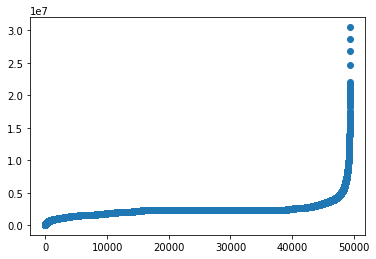

In [7]:
plt.scatter(range(len(predictions)), np.sort(predictions))

# ONLY WHEN FINISHED

In [10]:
# Cleaning up saved files
import shutil

shutil.rmtree(data_dir)
shutil.rmtree(model_dir)
shutil.rmtree(pred_dir)